In [5]:
import cv2, json
from matplotlib import pyplot as plt
import numpy as np
from lmfit import report_fit
from time import time
import os
import pandas as pd
import sys
from scipy.optimize import leastsq
from scipy.optimize import curve_fit
import trackpy as tp


#### This file includes various methods for data analysis

def load(filename, path='', refined=True):  ## Load data from json file
    filename = filename.split('.')[0]  ## Precaution, in case filename includes suffix
    if path is not '' and path[-1] is not '/':
        path = path + '/'
    if refined:
        with open(path+'refined/'+filename+'.json', 'r') as f:
            preds =  json.load(f)
    else:
        with open(path+'MLpreds/'+filename+'.json', 'r') as f:
            preds =  json.load(f)
    return pd.DataFrame.from_dict(preds)

              
################ Data Analysis Functions ########################
#### Methods for trajectories
def link(dat, relink=True, memory=5, maxdis=50): ## Use trackpy.link_df to find trajectories 
    if relink or ('particle' not in dat.columns):    
            dat = dat.rename(columns={"x_p": "x", "y_p": "y", "framenum": "frame"})
            dat = tp.link_df(dat, maxdis, memory=memory)
            dat = dat.rename(columns={"x": "x_p", "y": "y_p", "frame": "framenum"})
    return dat

# def remove_traj(dat, i):
#     dat.loc[dat['particle']==i, ['particle']] = -1
#     dat.loc[dat['particle']>i, ['particle']] -= 1
#     return dat

# def filter_trajlen(dat, minlength=200):
#     N = max(dat.particle) + 1
#     i=0
#     while i < N:
#         if np.size( dat.loc[dat['particle']==i, 'x_p'] ) < minlength:
#             dat = remove_traj(dat, i)
#             N -= 1
#         else:
#             i += 1
#     return dat

def remove_trajs(dat, index):
    index.sort(reverse=True)
    for i in index:
        dat.loc[dat['particle']==i, 'particle'] = -1
        dat.loc[dat['particle']>i, 'particle'] -= 1
    return dat
   
def filter_trajlen(dat, minlength=200):
    return remove_trajs(dat, [i for i in range(max(dat.particle)+1) if (np.size(dat.loc[dat['particle']==i, 'x_p']) < minlength) ])
                   
def swap_traj(dat, i, j):
    dat.temp = dat.particle
    dat.loc[dat['particle']==j, 'temp'] = i
    dat.loc[dat['particle']==i, 'temp'] = j
    
    dat.particle = dat.temp 
    del dat['temp']
    return dat

def truncate_traj(dat, i):
    dat = dat[dat.particle < i]
    return dat
    
def get_prop(dat, prop, i=None):
    if i is None:    #### if i is None (default), return list: Out[i] = property of particle i
        return [get_prop(dat, prop, i=i) for i in range( max(dat.particle)+1 )]

    if prop[0] is 'r':    ## Read 'radius'
        x = get_prop(dat, 'x_p' + prop[1:], i=i)
        y = get_prop(dat, 'y_p' + prop[1:], i=i)
        return np.sqrt(x**2 + y**2)
#         return np.sqrt( get_prop(dat, 'x_p' + prop[1:], i)**2 + get_prop(dat, 'x_p' + prop[1:], i)**2)
    
    elif prop[-1] is '0': ## Read 'without mean'
        x = get_prop(dat, prop[:-1], i=i)
        return x - np.mean(x) 
    
    else:                 ## Base case: get the property directly from dataframe
        return dat.loc[dat['particle']==i, prop].to_numpy()  
    
def sort_traj(dat, prop):
    vals = [np.mean(x) for x in get_prop(dat, prop)]
    index = np.argsort(vals)
    
    dat['temp'] = dat.particle
    for i in range(np.size(index)):
        dat.loc[dat['particle']==index[i], 'temp'] = i
    dat.particle = dat.temp 
    del dat['temp']
    return dat

def scatter_traj(dat, N=None):
    N = max(dat.particle) + 1 if N is None else N
    X = get_prop(dat, 'x_p')
    Y = get_prop(dat, 'y_p')
    for i in range(N):
        plt.scatter(X[i], Y[i], label='traj. {} ({} points)'.format(i, np.size(X[i])))
    plt.legend()

def quickload(filename, scatter=False, path=''):
    dat = load(filename, path=path)
    dat = link(dat)
    dat = filter_trajlen(dat, minlength = 400)
    if(scatter):
        scatter_traj(dat)
    return dat



Frame 910: 6 trajectories present.


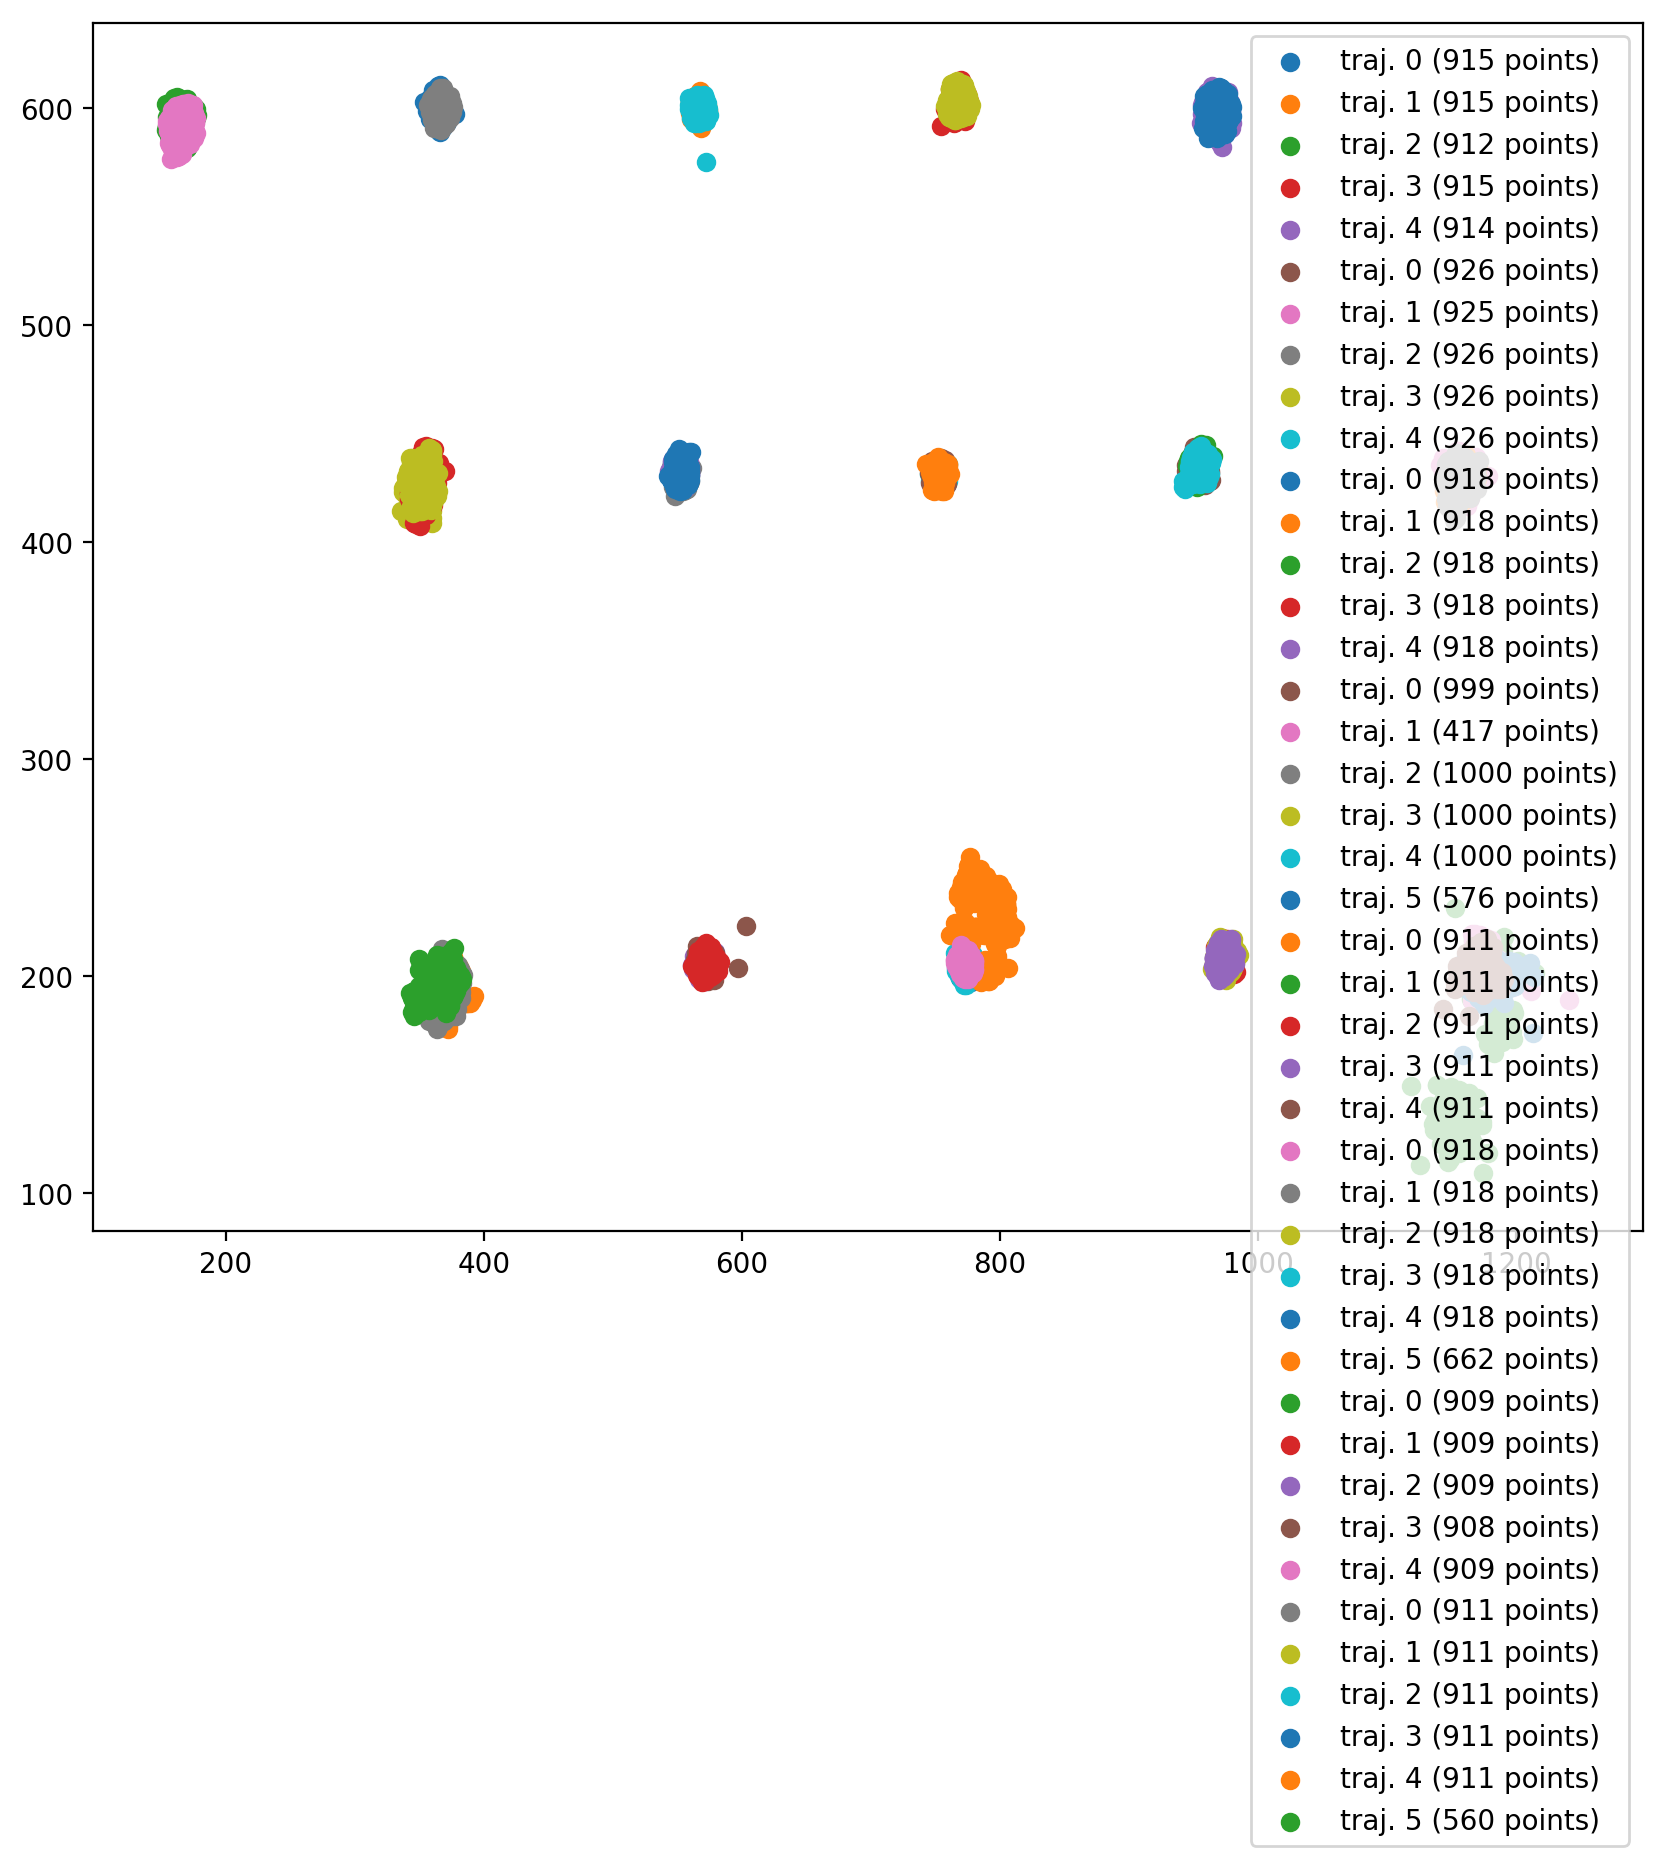

In [4]:
plt.rcParams['figure.figsize'] = [10, 8]
plt.rcParams['figure.dpi'] = 200


# d0 = quickload('3pt708hz_VPP10_1.json', scatter=True, path='six')


d00 = quickload('nofield1.json', scatter=True, path='five')
d01 = quickload('nofield2.json', scatter=True, path='five')
d02 = quickload('nofield3.json', scatter=True, path='five')

d10 = quickload('3pt078hz_vpp7_1.json', scatter=True, path='five')
d11 = quickload('3pt078hz_vpp7_2.json', scatter=True, path='five')
d12 = quickload('3pt078hz_vpp7_3.json', scatter=True, path='five')

d20 = quickload('3pt078hz_vpp10_1.json', scatter=True, path='five')
d21 = quickload('3pt078hz_vpp10_2.json', scatter=True, path='five')



# d0 = quickload('nofield.json', scatter=True, path='feb5')
# d1 = quickload('6pt18hz_Vpp1_l1', scatter=True, path='feb5')
# d2 = quickload('6pt18hz_Vpp4_l1', scatter=True, path='feb5')
# d3 = quickload('6pt18hz_Vpp7_l1', scatter=True, path='feb5')
# d4 = quickload('6pt18hz_Vpp10_l1', scatter=True, path='feb5')

# d1 = quickload('')
# d1 = quickload('6pt18hz_vpp10_long1.json', scatter=True)
# d2 = quickload('6pt18hz_vpp10_long2.json', scatter=True)


# d1 = quickload('6pt18hz_vpp3_l1', scatter=True)
# d2 = quickload('MLpreds/6pt18hz_vpp3_l2', scatter=True)
# d3 = quickload('MLpreds/618hz_vpp3_l3', scatter=True)
# d4 = quickload('MLpreds/6pt18hz_vpp3_l4', scatter=True)
plt.show()


FPS = 30
f = 6.18

In [6]:
# runs = [d0]
# num_runs = 1
# runs = [d0, d1, d2, d3, d4]
# num_runs = 5
# dim = 2  ## Number of particle trajectories to record each run

# runs = [d10, d11, d12]
# num_runs = 3
# runs = [d00, d01, d02]
# num_runs = 3

    


runs = [d11, d12]
num_runs = 1
dim = 5
#### Input: list of properties, list of dataframes, number of dataframes (length of list), number trajs to keep
#### Output: 3D list OUT[i][j][k] is property i of dataframe j for particle k
def runs2props(props, runs, num_runs, num_trajs, sortprop='x_p'):
    for i in range(len(runs)):                   #### Sort each run and keep only first 'num_trajs' trajectories
#         runs[i] = sort_traj( truncate_traj(runs[i], num_trajs), sortprop) 
        runs[i] = sort_traj( runs[i][runs[i].particle < num_trajs], sortprop) 
#     out = []
#     for prop in props:
#         print(prop)
#         X = []
#         for i in range(num_runs):
#             X.append(get_prop(runs[i], prop))
#         out.append(X)
#     return out
    return [ [get_prop(runs[i], prop) for i in range(num_runs)] for prop in props]
X, Y, R = runs2props(['x_p', 'y_p', 'r'], [d10, d11], 2, 5)
X0, Y0, R0 = runs2props(['x_p0', 'y_p0', 'r0'], [d10, d11], 2, 5)
# def df2XYR(runs, num_runs, dim, nomean=False):  
#     X = []
#     Y = []
#     R = []
#     XYR = []
#     props = ['x', 'y', 'r']
#     for i in range(num_runs):    
#         runs[i] = sort_traj( truncate_traj(runs[i], dim), 'x_p')

#         X.append(get_prop(runs[i], 'x_p'))
#         Y.append(get_prop(runs[i], 'y_p'))
#         R.append(get_prop(runs[i], 'r'))
#         X0.append(get_prop(runs[i], 'x_p0'))
#         Y0.append(get_prop(runs[i], 'y_p0'))

        
#         R0.append(get_prop(runs[i], 'r0'))

# #         X0.append([x - np.mean(x) for x in X[i]])
# #         Y0.append([y - np.mean(y) for y in Y[i]])

# #         R.append([np.sqrt(X[i][j]**2 + Y[i][j]**2) for j in range(dim)])
# #         R0.append([np.sqrt(X0[i][j]**2 + Y0[i][j]**2) for j in range(dim)])
#     return X, Y, R, X0, Y0, R0

# # X, Y, R, X0, Y0, R0 = df2XYR([d11], 1, 5)
#### Return the matrix (gamma*H) = C/|i-j|; C=(3a/2L)
def H0(dim, C=0.25):     
    H = np.ones([dim, dim])
    for i in range(dim):
        for j in range(dim):
            if i is not j:
                H[i, j] = C/abs(i-j)
                H[j, i] = C/abs(i-j)
    return H

LBDA, XI = np.linalg.eig( H0(dim) )
print(XI)
def getNormalModes(vals, XI):
    out = []
    count = 0
    for x in vals:
        count += 1
        out.append(0*x)
    for i in range(count):
        for j in range(count):
            out[i] += XI[i][j]*vals[j]
            
    return out
    
Xn = [getNormalModes(X[i], XI) for i in range(num_runs)]
Yn = [getNormalModes(Y[i], XI) for i in range(num_runs)]
X0n = [getNormalModes(X0[i], XI) for i in range(num_runs)]
Y0n = [getNormalModes(Y0[i], XI) for i in range(num_runs)]
Rn = [getNormalModes(R[i], XI) for i in range(num_runs)]
R0n = [getNormalModes(R0[i], XI) for i in range(num_runs)]


/home/users6/zds241/.local/lib/python3.6/site-packages/ipykernel_launcher.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/users6/zds241/.local/lib/python3.6/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/home/users6/zds241/.local/lib/python3.6/site-packages/pandas/core/generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the

[[-3.76787548e-01 -5.44125109e-01 -5.44681718e-01 -4.51583731e-01
   2.47695316e-01]
 [-4.77886780e-01 -4.51583731e-01  9.77846853e-02  5.44125109e-01
  -5.11920288e-01]
 [-5.09225627e-01  2.94858931e-16  6.22511013e-01 -5.79879536e-16
   5.94280489e-01]
 [-4.77886780e-01  4.51583731e-01  9.77846853e-02 -5.44125109e-01
  -5.11920288e-01]
 [-3.76787548e-01  5.44125109e-01 -5.44681718e-01  4.51583731e-01
   2.47695316e-01]]


ValueError: operands could not be broadcast together with shapes (1000,) (999,) (1000,) 

In [9]:
#### Methods for analyzing Correlation Functions
def corr(x1, x2):
    N = np.size(x1)
    out = np.zeros(N)
    for i in range(N):
        for j in range(N-i):
            out[i] += x1[j]*x2[j+i]
        #out[i] = out[i]/(N-i)
    out = out/(N-np.arange(N))
    return out 
#     return out/out[0]

def acorr(x, n=None):    
    return corr(x, x) if n is None else corr(x, x)[:n]
for run in runs:
    print(i)
    
print(len(runs))

0
0
2


In [10]:
# cX = []
# cY = []
# cR = []
# cX0 = []
# cY0 = []
# cR0 = []
# for i in range(num_runs):
#     cX.append([ acorr(a) for a in X[i] ])
#     cY.append([ acorr(a) for a in Y[i] ])
#     cR.append([ acorr(a) for a in R[i] ])
#     cX0.append([ acorr(a) for a in X0[i] ])
#     cY0.append([ acorr(a) for a in Y0[i] ])
#     cR0.append([ acorr(a) for a in R0[i] ])

cX = [ [acorr(a) for a in X[i]] for i in range(num_runs)] 
cY = [ [acorr(a) for a in Y[i]] for i in range(num_runs)] 
cR = [ [acorr(a) for a in R[i]] for i in range(num_runs)] 
cX0 = [ [acorr(a) for a in X0[i]] for i in range(num_runs)] 
cY0 = [ [acorr(a) for a in Y0[i]] for i in range(num_runs)] 
cR0 = [ [acorr(a) for a in R0[i]] for i in range(num_runs)] 

    
cXn = []
cYn = []
cRn = []
cX0n = []
cY0n = []
cR0n = []
for i in range(num_runs):
    cXn.append([ acorr(a) for a in Xn[i] ])
    cYn.append([ acorr(a) for a in Yn[i] ])
    cRn.append([ acorr(a) for a in Rn[i] ])
    cX0n.append([ acorr(a) for a in X0n[i] ])
    cY0n.append([ acorr(a) for a in Y0n[i] ])
    cR0n.append([ acorr(a) for a in R0n[i] ])

NameError: name 'Xn' is not defined

In [12]:
#### Methods for analyzing Particle Oscillation 
def fourier(x, FPS=30):    #### Fourier Transform. Assume no 'missing' frames.
    num_frames = np.size(x)
    fx = np.fft.rfft(x)*np.conjugate(np.fft.rfft(x))
    fx[0] = 0.0   #### Drop zero mode
    hz = FPS/num_frames*np.arange(np.size(fx))
    return hz, fx


def sinfunc(n, params):
    amp=params[0]
    freq=params[1] 
    phase=params[2]
    return amp*np.sin(2*np.pi*freq*n + phase)


def modsinfunc(n, params):
    amp=params[0]
    freq=params[1] 
    phase=params[2]
    depth = params[3]
    rate = params[4]
    shift = params[5]
    S = sinfunc(n, [amp, freq, phase])
    M = sinfunc(n, [1, rate, shift])
    return S*(1 - depth/2 + (depth/2)*M)
   
def sinfit(x, MOD=False, k0=0, framenum=None, guess=None, FPS=30): ## Fit to a sin (or amp-modulated sin) function. 
    guess = [max(x), k0, 0., 0.5, 1, 0.] if guess is None else guess
    framenum = np.arange(np.size(x)) if framenum is None else framenum
    t = framenum/FPS
    
    func = modsinfunc if MOD else sinfunc
    def residual(params, data, n):
        return data - func(n, params)
    
    X, trash = leastsq(residual, guess, args=(x, t))
#     return X, trash
    return X, func(t, X)   

def expfunc(n, params):
    A = params[0]
    tau = params[1]
    return A*np.exp(-n/tau)
    
def expfit(C, framenum=None, guess=None, FPS=30):
    guess = [C[0], 2/FPS] if guess is None else guess
    framenum = np.arange(np.size(C)) if framenum is None else framenum
    t = framenum/FPS    
        
    func = expfunc
    def residual(params, data, n):
        return data - func(n, params)
    
    X, trash = leastsq(residual, guess, args=(C, t))
    #   return X, trash
    return X, expfunc(t, X)   


In [13]:
# ##############   Plotting Functions #################
# def plot_array(xvals, funcs, nomean=False):
#     rows = np.shape(xvals)[0]
#     cols = np.size(funcs)
#     for i in range(cols):
#         func = funcs[i]
#         for j in range(rows):
#             plt.subplot(rows, cols, i+j*cols+1)
#             if(nomean):
#                 func(xvals[j] - np.mean(xvals[j]))
#             else:
#                 func(xvals[j])
            
def getindex(rows, cols, i, j):
    return (j*cols) + i

def toplabel(rows, cols, labels):
    for i in range(cols):
        plt.subplot(rows, cols, i+1)
        plt.title(labels[i])
        
def botlabel(rows, cols, labels):
    for i in range(cols):
        plt.subplot(rows, cols, cols*(rows-1) + i+1)
        plt.xlabel(labels[i])
        
def leftlabel(rows, cols, labels):
    for i in range(rows):
        plt.subplot(rows, cols, i*cols + 1)
        plt.ylabel(labels[i])


In [14]:
%matplotlib qt

###### MAIN PLOTTING FUNC ###############
#### In this case, each row is a different value, and each column is a different function
#### column 1: raw data  |  column 2: fourier transform  |  column 3: autocorrelation function

def plotStuff1(rows, vals, cvals=None, labels=None):
    cols = 3
    for i in range(rows):
        
        plt.subplot(rows, cols, (i*cols) + 2)
        hz, ft = fourier(vals[i])
        plt.plot(hz, ft)

        
        plt.subplot(rows, cols, (i*cols) + 3)
        n = 25
        params, x = expfit(cvals[i])
        str2 = 'C[0]={:.3f} | FIT: C[0]={:.3f}, tau={:.3f}'.format(cvals[i][0], params[0], params[1])
        color=next(plt.gca()._get_lines.prop_cycler)['color']
        plt.plot(cvals[i][:n], color=color)
        plt.plot(x[:n], linestyle=':', color=color)
                
        plt.title(str2)
        
        plt.subplot(rows, cols, (i*cols) + 1)
        plt.plot(vals[i])
        
        k0 = np.where( ft==max(ft) )[-1][0] 
        params, x = sinfit(vals[i], k0=hz[k0])
        str1 = '{}: f={:.3f} | FIT: A={:.3f}, f={:.3f}, phi={:.3f}'.format(labels[i], hz[k0], params[0], params[1], params[2])
        plt.title('A={:.3f}, f={:.3f}, phi={:.3f}'.format(params[0], params[1], params[2]))
    
        print(str1+'  ||  ' + str2)
    


#     toplabel(rows, cols, ['raw', 'fourier', 'autocorrelation'])
    leftlabel(rows, cols, labels)

print(np.shape(X0))
    
i = 1
rows=4
# plt.figure(1)
# plotStuff1(4, X0[i], cX0[i], ['X0', 'X1', 'XP', 'XM'])

# plt.figure(2)
# plotStuff1(4, Y0[i], cY0[i], ['Y0', 'Y1', 'YP', 'YM'])

# plt.figure(3)
# plotStuff1(4, R0[i], cR0[i], ['R0', 'R1', 'RP', 'RM'])

i = 0
rows=dim
plt.figure(1)
plotStuff1(dim, X0[i], cX0[i], ['X{}'.format(i) for i in range(dim)])
plt.figure(2)
plotStuff1(dim, Y0[i], cY0[i], ['Y{}'.format(i) for i in range(dim)])
plt.figure(3)
plotStuff1(dim, R0[i], cR0[i], ['R{}'.format(i) for i in range(dim)])






# i = 2
# rows=dim
# plt.figure(4)
# plotStuff1(dim, X0n[i], cX0n[i], ['Xn{}'.format(i) for i in range(dim)])
# plt.figure(5)
# plotStuff1(dim, Y0n[i], cY0n[i], ['Yn{}'.format(i) for i in range(dim)])
# plt.figure(6)
# plotStuff1(dim, R0n[i], cR0n[i], ['Rn{}'.format(i) for i in range(dim)])





    

(2, 5)
X0: f=0.270 | FIT: A=-1.744, f=0.265, phi=0.536  ||  C[0]=19.390 | FIT: C[0]=21.071, tau=0.164
X1: f=0.360 | FIT: A=-1.305, f=0.362, phi=0.468  ||  C[0]=13.113 | FIT: C[0]=12.161, tau=0.154
X2: f=0.060 | FIT: A=0.606, f=0.065, phi=-1.940  ||  C[0]=6.732 | FIT: C[0]=6.849, tau=0.068


/home/users6/zds241/.local/lib/python3.6/site-packages/numpy/core/numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


X3: f=0.090 | FIT: A=1.076, f=0.094, phi=-0.078  ||  C[0]=8.699 | FIT: C[0]=8.316, tau=0.129
X4: f=0.144 | FIT: A=3.603, f=0.151, phi=0.743  ||  C[0]=42.063 | FIT: C[0]=32.456, tau=0.168
Y0: f=0.060 | FIT: A=2.375, f=0.050, phi=0.545  ||  C[0]=28.737 | FIT: C[0]=26.481, tau=0.407


/home/users6/zds241/.local/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


Y1: f=0.901 | FIT: A=-0.864, f=0.891, phi=1.714  ||  C[0]=7.749 | FIT: C[0]=7.768, tau=0.099
Y2: f=0.840 | FIT: A=-0.691, f=0.843, phi=0.614  ||  C[0]=6.557 | FIT: C[0]=6.523, tau=0.086
Y3: f=0.720 | FIT: A=0.863, f=0.719, phi=-0.238  ||  C[0]=8.124 | FIT: C[0]=8.319, tau=0.084
Y4: f=0.144 | FIT: A=-4.092, f=0.143, phi=0.838  ||  C[0]=35.361 | FIT: C[0]=35.324, tau=0.377
R0: f=0.090 | FIT: A=2.150, f=0.105, phi=-0.255  ||  C[0]=48.127 | FIT: C[0]=42.191, tau=70.910
R1: f=0.901 | FIT: A=-0.511, f=0.901, phi=1.133  ||  C[0]=20.862 | FIT: C[0]=16.514, tau=6376539815.023
R2: f=2.310 | FIT: A=-0.350, f=2.298, phi=2.321  ||  C[0]=13.289 | FIT: C[0]=10.892, tau=2910237781.046
R3: f=0.810 | FIT: A=-0.538, f=0.800, phi=1.447  ||  C[0]=16.823 | FIT: C[0]=13.379, tau=311.237
R4: f=0.432 | FIT: A=-2.735, f=0.459, phi=-2.794  ||  C[0]=77.424 | FIT: C[0]=55.714, tau=104397571.661


In [494]:
rows=dim
for i in range(num_runs):
    print('Run {}'.format(i))

    plt.figure(1)
    plotStuff1(dim, X0[i], cX0[i], ['X{}'.format(i) for i in range(dim)])
    plt.figure(2)
    plotStuff1(dim, Y0[i], cY0[i], ['Y{}'.format(i) for i in range(dim)])
    plt.figure(3)
    plotStuff1(dim, R0[i], cR0[i], ['R{}'.format(i) for i in range(dim)])

Run 0
X0: f=0.099 | FIT: A=-1.806, f=0.095, phi=0.075  ||  C[0]=16.961 | FIT: C[0]=17.033, tau=0.152
X1: f=0.593 | FIT: A=1.049, f=0.595, phi=-1.824  ||  C[0]=8.609 | FIT: C[0]=8.399, tau=0.116
X2: f=0.823 | FIT: A=-1.244, f=0.826, phi=0.619  ||  C[0]=14.404 | FIT: C[0]=15.094, tau=0.155
X3: f=1.712 | FIT: A=0.871, f=1.721, phi=-2.327  ||  C[0]=9.444 | FIT: C[0]=9.800, tau=0.072
X4: f=0.790 | FIT: A=0.701, f=0.797, phi=-0.206  ||  C[0]=6.053 | FIT: C[0]=6.208, tau=0.064
Y0: f=0.198 | FIT: A=1.785, f=0.211, phi=-1.990  ||  C[0]=15.504 | FIT: C[0]=15.007, tau=0.180
Y1: f=0.560 | FIT: A=1.063, f=0.550, phi=2.527  ||  C[0]=8.331 | FIT: C[0]=8.393, tau=0.098
Y2: f=0.066 | FIT: A=1.993, f=0.071, phi=-0.463  ||  C[0]=24.096 | FIT: C[0]=23.012, tau=0.267
Y3: f=0.231 | FIT: A=0.918, f=0.240, phi=-1.445  ||  C[0]=7.076 | FIT: C[0]=6.964, tau=0.095
Y4: f=0.461 | FIT: A=-0.820, f=0.463, phi=-1.185  ||  C[0]=5.698 | FIT: C[0]=5.703, tau=0.061
R0: f=0.461 | FIT: A=0.778, f=0.445, phi=-2.556  ||  C[0

In [275]:
#### Test the resolution of the autocorr function for different length trajectories
for i in range(num_modes):
    plt.figure(i)
    plot_array([X[i][0], X[i][0][0:3000], X[i][0][0:1000], X[i][0][0:500]], [func_acorrfit], nomean=True)
    leftlabel(2*num_modes, 1, ['Full', '3000 Points', '1000 Points', '500 Points'])
    toplabel(2*num_modes, 1, ['acorr'])
    botlabel(2*num_modes, 1, ['seconds'])

    plt.show()

IndexError: list index out of range

In [309]:
##### Extracting trap stiffness + related data
kB = 1.3806*10**-23
T = 308.15 ##35 degrees celcius
var = 9.3
k = kB*T/var

tau=0.015




In [ ]:
def paramStuff(numvals, vals):
    for i in range(numvals):
        
    

In [418]:
print(int(0.9))


0


In [299]:
#### Function for extracting stuff for two-particle trajectories

runs = [d0, d1, d2, d3, d4]
num_runs = 5

def nomean(df):
    for i in range(max(df.particle)+1):
        df.loc[df['particle']==i, 'x_p'] -= np.mean(df.loc[df['particle']==i, 'x_p'])
        df.loc[df['particle']==i, 'y_p'] -= np.mean(df.loc[df['particle']==i, 'y_p'])
    return df

def twomodes(df):
    X = [df[df.particle==0].x_p.to_numpy(), df[df.particle==1].x_p.to_numpy()] 
    X.append( (X[0]+X[1])/2 )
    X.append( X[1]-X[0] )
    
    Y = [df[df.particle==0].y_p.to_numpy(), df[df.particle==1].y_p.to_numpy()] 
    Y.append( (Y[0]+Y[1])/2 )
    Y.append( Y[1]-Y[0] )
     
    R = [np.sqrt(x[i]**2 + y[i]**2) for i in range(4)] 
    
    
    
    return X, Y, R


X = []
Y = []
R = []
X0 = []
Y0 = []
R0 = []
for i in range(num_runs):
    x, y, r= twomodes(runs[i])
    X.append(x)
    Y.append(y)
    R.append(r)
    
    x, y, r = twomodes(nomean(runs[i]))
    X0.append(x)
    Y0.append(y)
    R0.append([a - np.mean(a) for a in r])
#     R0.append( [r - np.mean(r) for r in R[i]] )
# print(np.shape(X))
# print(np.shape(Y))
# print(np.shape(R))
# print(np.shape(X0))
# print(np.shape(Y0))
# print(np.shape(R0))